# Problema de Laplace en medio cilindro
En este notebook vemos cómo calcular algunas integrales que aparecen en el cálculo del potencial electrostático en el interior de medio cilindro de radio a y altura h (con las tapas en z = h/2 y z = -h/2 a un potencial V), y luego cómo graficar el resultado usando el desarrollo obtenido a partir de resolver el problema de Laplace. Para lo primero usamos SymPy (https://docs.sympy.org/latest/tutorial/calculus.html), mientras que para lo segundo usamos loops en Python (https://wiki.python.org/moin/ForLoop) junto con NumPy, SciPy para funciones especiales, y Matplotlib para graficar los resultados. Recuerden que cada celda a continuación debe ejecutarse en orden, apretando SHIFT+ENTER:

## Cálculo de integrales en forma simbólica
Veamos cómo calcular integrales indefinidas y definidas en forma simbólica usando SymPy.

In [1]:
# El código en esta celda asegura que SymPy funcione correctamente en Google colab o en sus computadoras
import os
if "COLAB_GPU" in os.environ:
  from sympy import *
  def custom_latex_printer(expr, **options):
      from IPython.display import Math, HTML
      from google.colab.output._publish import javascript
      url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-AMS_CHTML"
      javascript(content="""window.MathJax = { tex2jax: { inlineMath: [ ['$','$'] ], processEscapes: true } };""")
      javascript(url=url)
      return latex(expr, **options)
  init_printing(use_latex="mathjax", latex_printer=custom_latex_printer)
else:
  from sympy import *
  init_printing()

In [2]:
# Definimos variables simbólicas; noten que definimos a m y n como enteros positivos
m,n = symbols("m,n", integer=True, positive=True)
phi = symbols("phi", real=True)

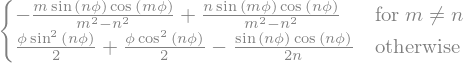

In [3]:
# Calculamos la integral indefinida del producto de senos
integrate(sin(n*phi)*sin(m*phi), phi)

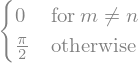

In [4]:
# Calculamos la integral definida del producto de senos en el intervalo [0,pi]
integrate(sin(n*phi)*sin(m*phi), (phi,0,pi))

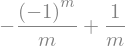

In [5]:
# Calculamos la integral de sin(m.phi) en el intervalo [0,pi]
integrate(sin(m*phi), (phi,0,pi))

## Cálculo numérico del potencial
Ahora usamos NumPy, SciPy y Matplotlib para estimar numéricamente el potencial y graficarlo. Usamos rutinas de integración numérica por cuadraturas de SciPy (https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html). Comenzamos importando los módulos, y definiendo (en unidades adimensionales arbitrarias) valores para a y para h. Luego construimos arrays que contienen los ceros de las funciones de Bessel, y los coeficientes C_mn de la expansión.

In [6]:
# Importamos NumPy, Matplotlib, y funciones especiales y de integración en SciPy
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import *

In [7]:
# Definimos las longitudes características del cilindro y el valor del potencial en las tapas en unidades adimensionales
a = 1.  # radio del cilindro
h = 2*a # altura del cilindro
V = 1.  # potencial en las tapas

In [8]:
# Definimos cuántos términos de la serie vamos a calcular
m_max = np.int(30) # máximo valor de m (=nu)
n_max = np.int(30) # máximo valor de n (raíz n-ésima de la función de Bessel J_m)

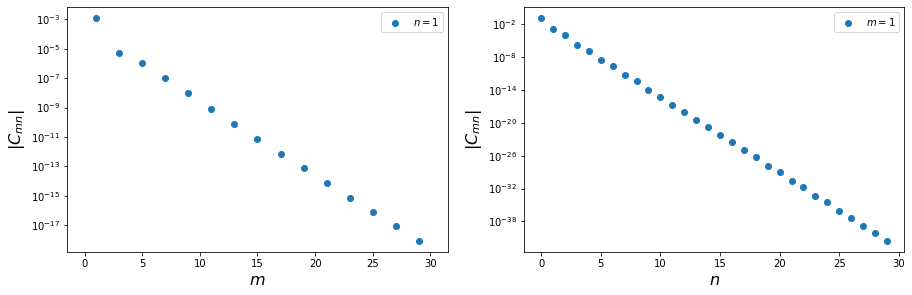

In [9]:
# Definimos una función con el integrando que aparece en la integral de los coeficientes C_mn
def integrand(x,nu,nzero,radius):
    return x*jv(nu,nzero*x/radius)

# Construimos un array que tenga los zeros de Bessel x[m,n]. Usamos un bucle "for" para calcular para todos los valores de nu (o m).
xmn = np.zeros((m_max+1,n_max))
for m in range(0,m_max+1):
    xmn[m,:] = jn_zeros(m, n_max)

# Construimos un array que tenga los C[m,n]; usamos quad (cuadratuas) para calcular las integrales. Nuevamente usamos bucles para barrer todos los valores de m y n.
C = np.zeros((m_max+1,n_max))
for m in range(1,m_max+1,2):    # calculamos solo los m impares, el resto son ceros
    for n in range(0,n_max):    # todos los valores de n desde 0 hasta n_max
        integral = quad(integrand, 0, a, args=(m,xmn[m,n],a))
        C[m,n] = 8*V*integral[0]/(m*np.pi*a**2*np.cosh(xmn[m,n]*h/(2*a))*jv(m+1,xmn[m,n])**2)

# Veamos que los coeficientes se vuelven pequeños rápidamente graficando sus módulos
plt.figure(figsize=(15,4.5))
plt.subplot(1, 2, 1)
plt.semilogy(np.arange(0,m_max+1), abs(C[:,1]), 'o', label='$n=1$')
plt.legend(fontsize=10)
plt.xlabel(r'$m$',fontsize=16)
plt.ylabel(r'$|C_{mn}|$',fontsize=16)
plt.subplot(1, 2, 2)
plt.semilogy(np.arange(0,n_max), abs(C[1,:]), 'o', label='$m=1$')
plt.legend(fontsize=10)
plt.xlabel(r'$n$',fontsize=16)
plt.ylabel(r'$|C_{mn}|$',fontsize=16)
plt.show()

Ahora construimos una función que nos devuelva el valor del potencial electrostático en un punto (rho, phi, z) en coordenadas cilíndricas. Noten como usamos bucles para sumar en forma incremental sobre todos los valores de n y m. Luego usamos esa función para graficar perfiles del potencial en función de las coordenadas cilíndricas.

In [10]:
# Definimos una función que devuelva el valor del potencial en un punto:
def psi(r,p,z):
    out = 0.                        # inicializamos la variable out a cero
    for m in range(1,m_max+1,2):    # sumamos solo sobre m impares, el resto son ceros
        for n in range(0,n_max):
            out = out + C[m,n]*np.sin(m*p)*jv(m,xmn[m,n]*r/a)*np.cosh(xmn[m,n]*z/a)
    return out

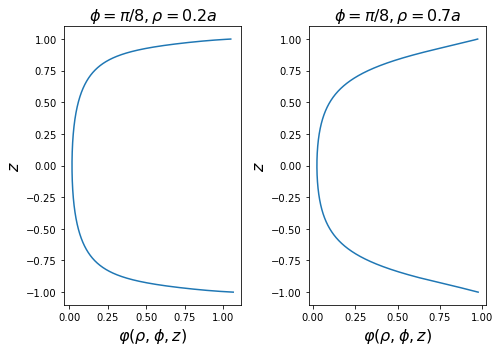

In [11]:
# Graficamos cortes del potencial en función de z para diferentes valores de rho (con phi fijo):
phi    = np.pi/8
zrange = np.arange(-h/2,h/2,.001)   # generamos un vector con z entre -h/2 y h/2, con paso de 0.001

plt.figure(figsize=(7,5))
plt.subplot(1, 2, 1)
r   = .2*a
plt.plot(psi(r,phi,zrange),zrange)
plt.xlabel(r'$\varphi(\rho,\phi,z)$',fontsize=16)
plt.ylabel(r'$z$',fontsize=16)
plt.title(r'$\phi = \pi/8, \rho = 0.2a$',fontsize=16)
plt.tight_layout()
plt.subplot(1, 2, 2)
r   = .7*a
plt.plot(psi(r,phi,zrange),zrange)
plt.xlabel(r'$\varphi(\rho,\phi,z)$',fontsize=16)
plt.ylabel(r'$z$',fontsize=16)
plt.title(r'$\phi = \pi/8, \rho = 0.7a$',fontsize=16)
plt.tight_layout()
plt.show()

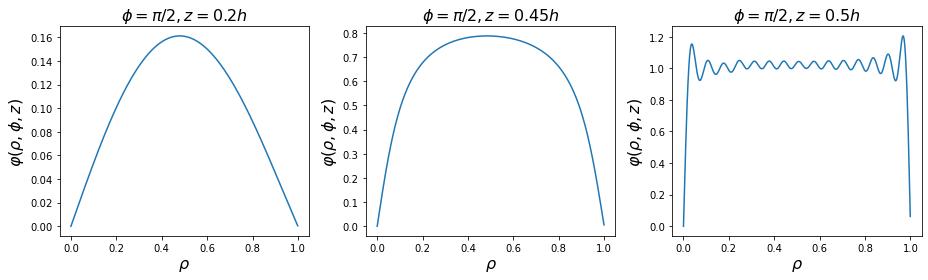

In [12]:
# Graficamos cortes del potencial en función de rho para diferentes valores de z (con phi fijo):
phi = np.pi/2
rho = np.arange(0,a,.001)   # generamos un vector con rho entre 0 y a, con paso de 0.001

plt.figure(figsize=(13,4))
plt.subplot(1, 3, 1)
z   = .2*h
plt.plot(rho,psi(rho,phi,z))
plt.xlabel(r'$\rho$',fontsize=16)
plt.ylabel(r'$\varphi(\rho,\phi,z)$',fontsize=16)
plt.title(r'$\phi = \pi/2, z = 0.2h$',fontsize=16)
plt.tight_layout()
plt.subplot(1, 3, 2)
z   = .45*h
plt.plot(rho,psi(rho,phi,z))
plt.xlabel(r'$\rho$',fontsize=16)
plt.ylabel(r'$\varphi(\rho,\phi,z)$',fontsize=16)
plt.title(r'$\phi = \pi/2, z = 0.45h$',fontsize=16)
plt.tight_layout()
plt.subplot(1, 3, 3)
z   = .5*h
plt.plot(rho,psi(rho,phi,z))
plt.xlabel(r'$\rho$',fontsize=16)
plt.ylabel(r'$\varphi(\rho,\phi,z)$',fontsize=16)
plt.title(r'$\phi = \pi/2, z = 0.5h$',fontsize=16)
plt.tight_layout()
plt.show()

Finalmente, graficamos cortes con el valor del potencial en el plano (rho,z) y (rho,phi). Para eso tenemos que generar una malla 2D con los valores de los pares de coordenadas (por ejemplo, para rho y z, con phi constante). Esto se puede hacer en NumPy usando el comando "meshgrid", a partir de vectores que tengan los valores de rho y z. Y para graficar el potencial usamos el comando "pcolormesh" de Matplotlib:

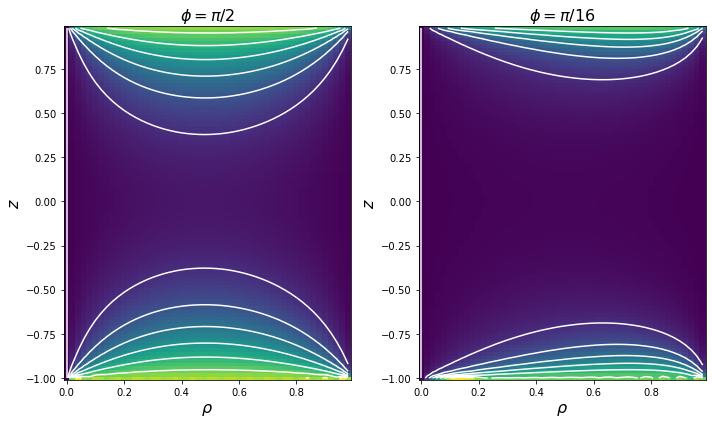

In [13]:
# Empezamos con el plano (rho,z) a phi constante; generamos vectores con los valores de rho y z, y la malla 2D:
rho = np.arange(0,a,.02)
z   = np.arange(-h/2,h/2,.02)
rmesh,zmesh = np.meshgrid(rho,z)

plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
phi = np.pi/2
plt.pcolormesh(rho,z,psi(rmesh,phi,zmesh),shading='auto')
plt.contour(rho,z,psi(rmesh,phi,zmesh),colors=['white'])
plt.xlabel(r'$\rho$',fontsize=16)
plt.ylabel(r'$z$',fontsize=16)
plt.title(r'$\phi = \pi/2$',fontsize=16)
plt.tight_layout()
plt.subplot(1, 2, 2)
phi = np.pi/16
plt.pcolormesh(rho,z,psi(rmesh,phi,zmesh),shading='auto')
plt.contour(rho,z,psi(rmesh,phi,zmesh),colors=['white'])
plt.xlabel(r'$\rho$',fontsize=16)
plt.ylabel(r'$z$',fontsize=16)
plt.title(r'$\phi = \pi/16$',fontsize=16)
plt.tight_layout()
plt.show()

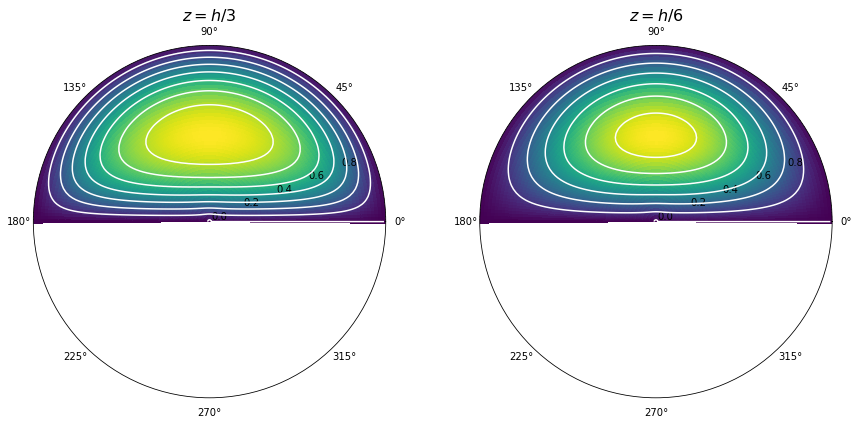

In [14]:
# Ahora miramos el plano (rho,phi) a z constante; generamos vectores con los valores de rho y phi, y la malla 2D:
rho = np.arange(0,a,.02)
phi = np.arange(0,np.pi,.02)
pmesh,rmesh = np.meshgrid(phi,rho)

fig = plt.figure(figsize=(13,6))
fig.add_subplot(121,polar='True')
z = h/3
plt.pcolormesh(pmesh,rmesh,psi(rmesh,pmesh,z),shading='auto')
plt.contour(phi,rho,psi(rmesh,pmesh,z),colors=['white'])
plt.title(r'$z = h/3$',fontsize=16)
plt.tight_layout()
fig.add_subplot(122,polar='True')
z = h/6
plt.pcolormesh(pmesh,rmesh,psi(rmesh,pmesh,z),shading='auto')
plt.contour(phi,rho,psi(rmesh,pmesh,z),colors=['white'])
plt.title(r'$z = h/6$',fontsize=16)
plt.tight_layout()
plt.show()